In [1]:
#
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.reset_default_graph()

Import MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets('mnist')

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


Some settings

# Tying weights

It is common to tie the weights of the encoder and the decoder. So, $W_{L} = W_{N-L+1}^T$ where $L<=N/2$. To do it, we have to explicitly manipulate the weights so that tf.layers.dense is NOT a good option. We have to build autoencoder manually.

Some settings

In [5]:
#
tf.reset_default_graph()
n_inputs = 28*28
n_hidden1 = 200
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

Build the network using he initializer and l2 regularization and ELU activation function.

In [6]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [7]:
initializer = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
activation = tf.nn.elu

In [8]:
with tf.name_scope('nn'):
    weight1_init = initializer([n_inputs, n_hidden1])
    weight2_init = initializer([n_hidden1, n_hidden2])
    
    weight1 = tf.Variable(weight1_init, dtype=tf.float32, name='weight1')
    weight2 = tf.Variable(weight2_init, dtype=tf.float32, name='weight2')
    
    weight3 = tf.transpose(weight2, name='weight3')
    weight4 = tf.transpose(weight1, name='weight4')
    
    bias1 = tf.Variable(tf.zeros(n_hidden1), dtype=tf.float32, name='bias1')
    bias2 = tf.Variable(tf.zeros(n_hidden2), dtype=tf.float32, name='bias2')
    bias3 = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32, name='bias3')
    bias4 = tf.Variable(tf.zeros(n_outputs), dtype=tf.float32, name='bias4')
    
    hidden1 = activation(tf.matmul(X, weight1) + bias1)
    hidden2 = activation(tf.matmul(hidden1, weight2) + bias2)
    hidden3 = activation(tf.matmul(hidden2, weight3) + bias3)
    output = activation(tf.matmul(hidden3, weight4) + bias4)
    
    

Construct the loss, including the base loss and regularization loss.

In [9]:
with tf.name_scope('loss'):
    base_loss = tf.reduce_mean(tf.square(output-X))
    reg_loss  = regularizer(weight1) + regularizer(weight2)
    loss = base_loss + reg_loss

Construct the training operation

In [10]:
with tf.name_scope('training'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

Excecute the training by 5 epoches with batch size of 150. Save the model to mnist/autoencoder_tying_weight.ckpt

In [11]:
n_epoch = 5
batch_size = 150
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    n_batch = mnist.train.num_examples // batch_size
    for epoch in range(n_epoch):
        for iteration in range(n_batch):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val = sess.run(loss, feed_dict={X: X_batch})
        print(epoch, loss_val)
    saver.save(sess, 'mnist/autoencoder_tying_weight.ckpt')

0 0.03571307
1 0.03513201
2 0.033766344
3 0.034093555
4 0.038636982


In another session, restore the variables from the saved file. Then predict the output at the first two test image

In [12]:
with tf.Session() as sess:
    saver.restore(sess, 'mnist/autoencoder_tying_weight.ckpt')
    X_test = mnist.test.images[:2]
    outputs_val = output.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from mnist/autoencoder_tying_weight.ckpt


Visualize the first two test images. To compare, also visualize their predictions.

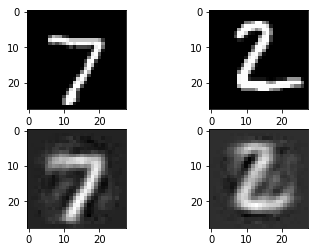

In [13]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(mnist.test.images[0].reshape(-1, 28), cmap='gray')
axes[0, 1].imshow(mnist.test.images[1].reshape(-1, 28), cmap='gray')
axes[1, 0].imshow(outputs_val[0].reshape(-1, 28), cmap='gray')
axes[1, 1].imshow(outputs_val[1].reshape(-1, 28), cmap='gray')